# Slice stepout

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.toy
import pints.plot
import pints.cptests.slice_stepout_mcmc as ss

from utils import run_replicates, ecdf_norm_plotter

parallel = True

# Two dimensional Gaussian

In [2]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 5000, 8), 10, ss.two_dim_gaussian, parallel=parallel)
print(t.format())

58.96 seconds


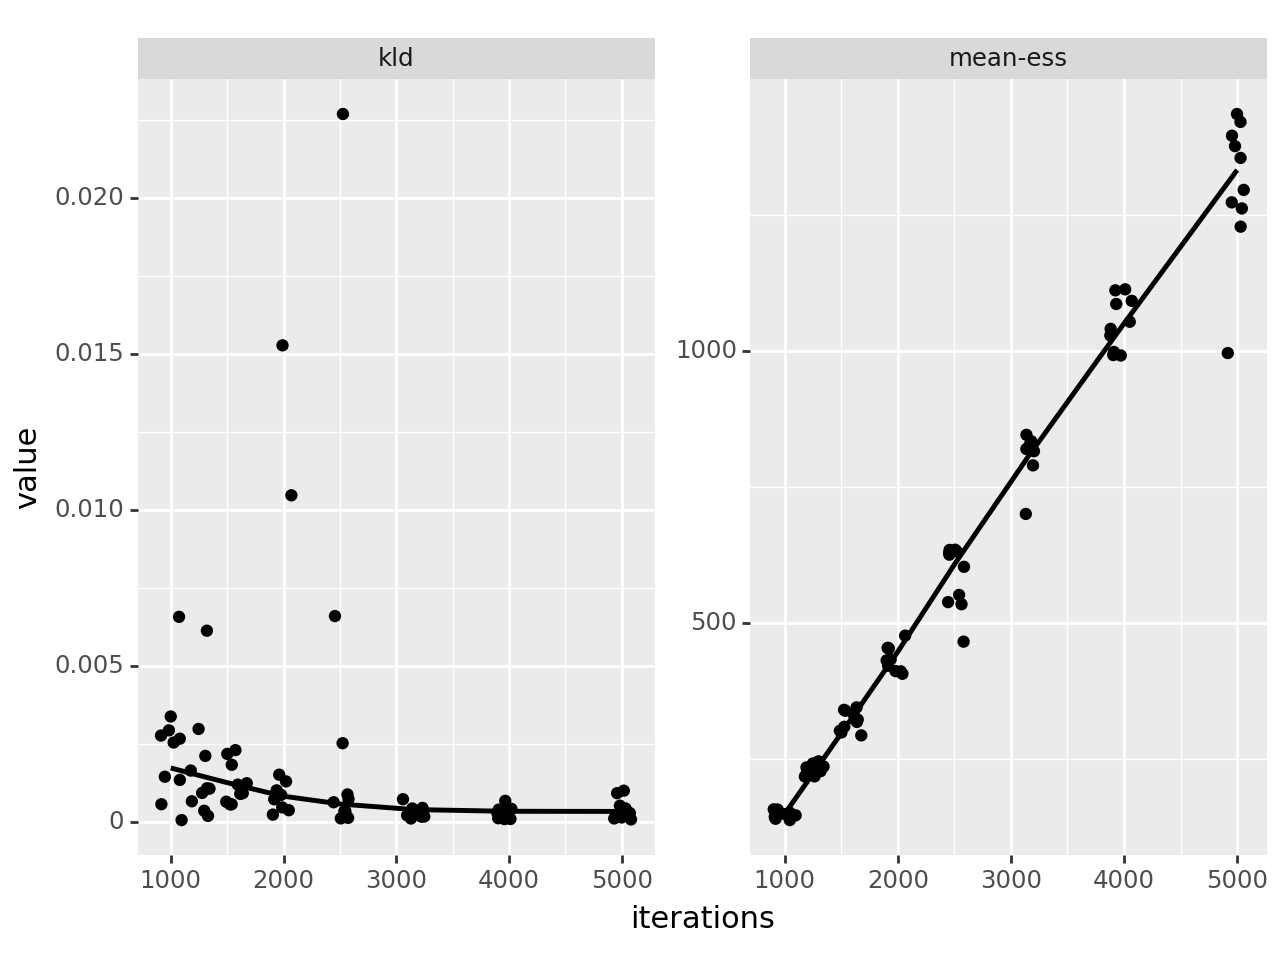

<Figure Size: (640 x 480)>

In [3]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))

The ESS and KLD both trend in the correct directions.

Show example run results.

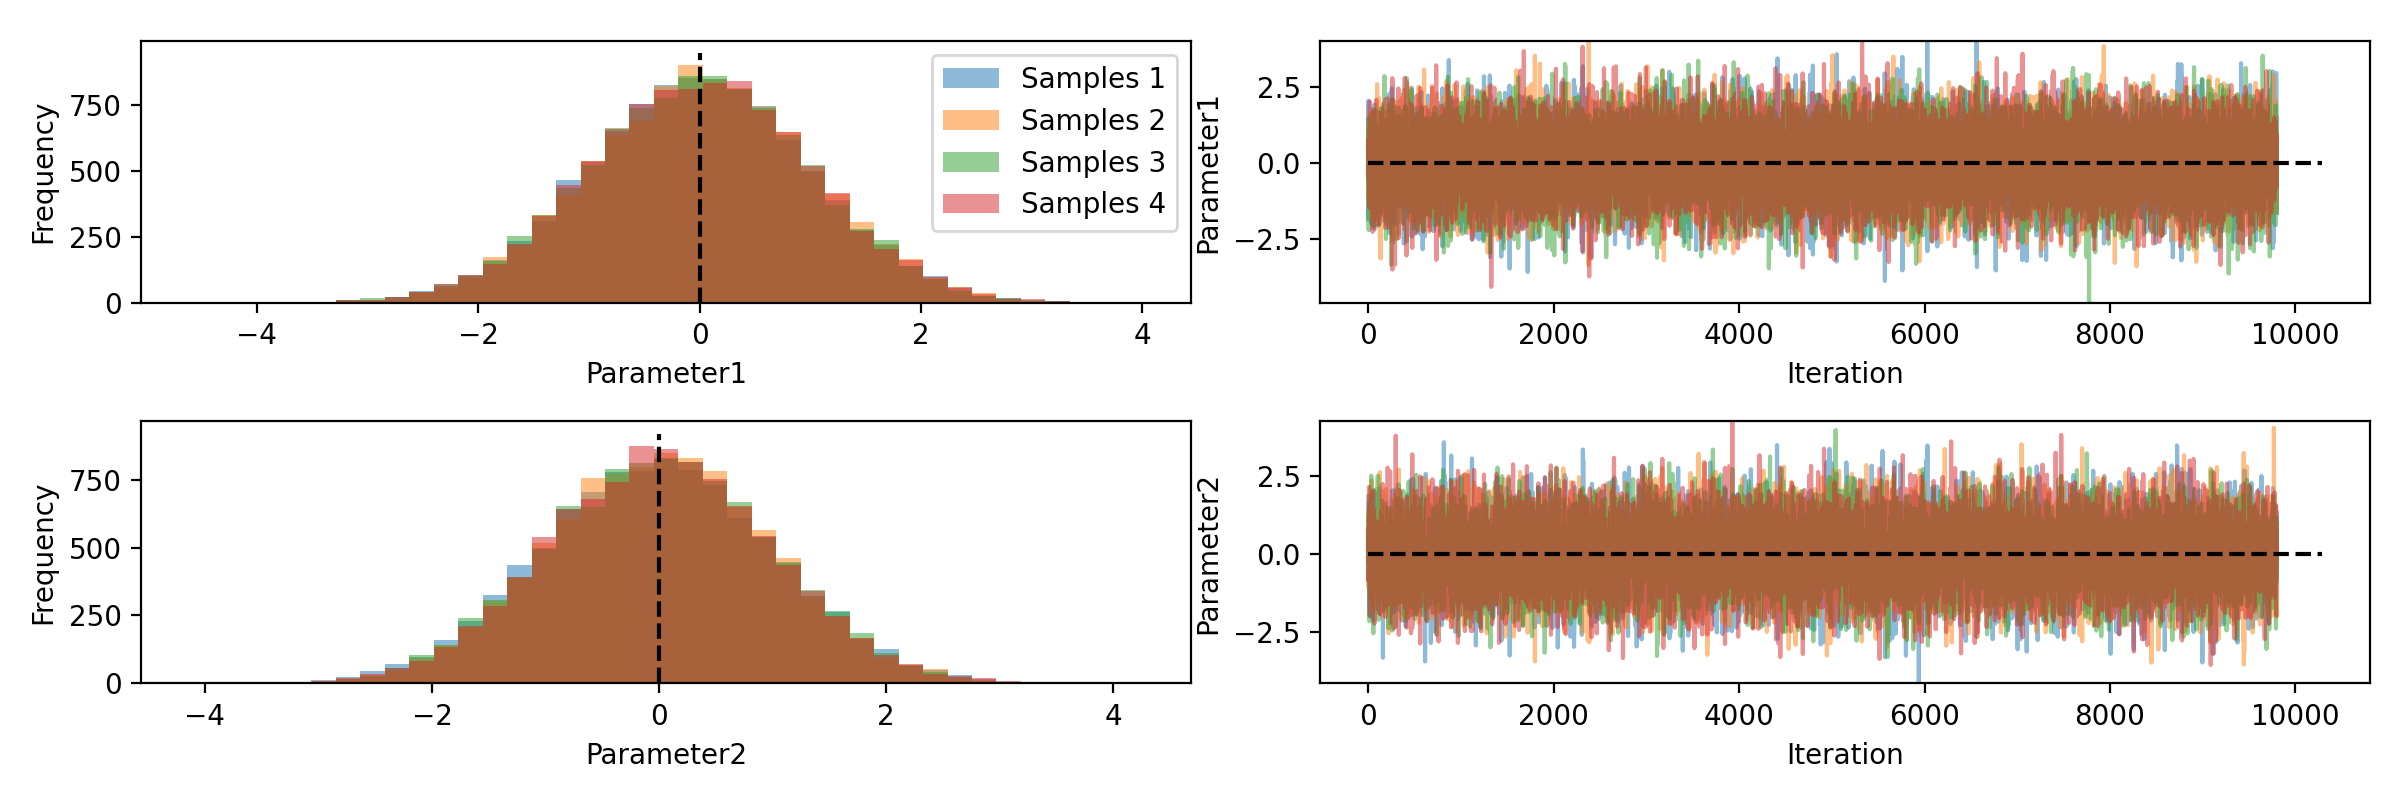

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess       ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  --------  --------------
param 1  0.00    1.01    -1.97   -0.68  0.01   0.68   1.97     1.00    12607.58  1100.81
param 2  -0.00   1.00    -1.95   -0.69  -0.00  0.67   1.94     1.00    9958.15   869.48


In [4]:
n_chains = 4
n_iterations = 10000
n_warmup = 200
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

# Get initial parameters
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)
controller = pints.MCMCController(
            log_pdf, n_chains, x0, method=pints.SliceStepoutMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.trace(chains, ref_parameters=[0, 0])

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

The parameters are close to their true means. How do they compare to MCMC eCDFs compare with the theoretical? Look pretty good.

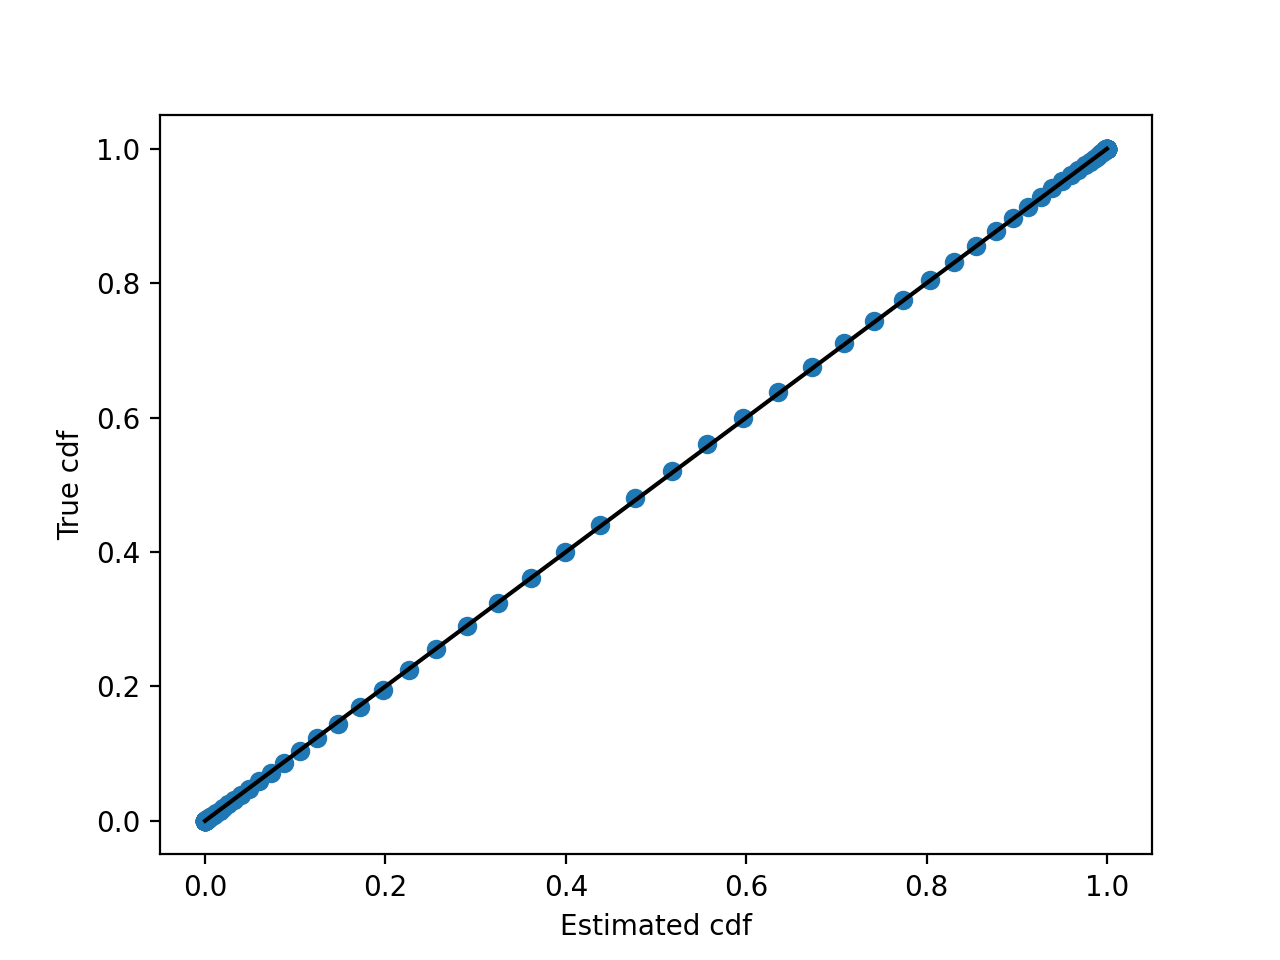

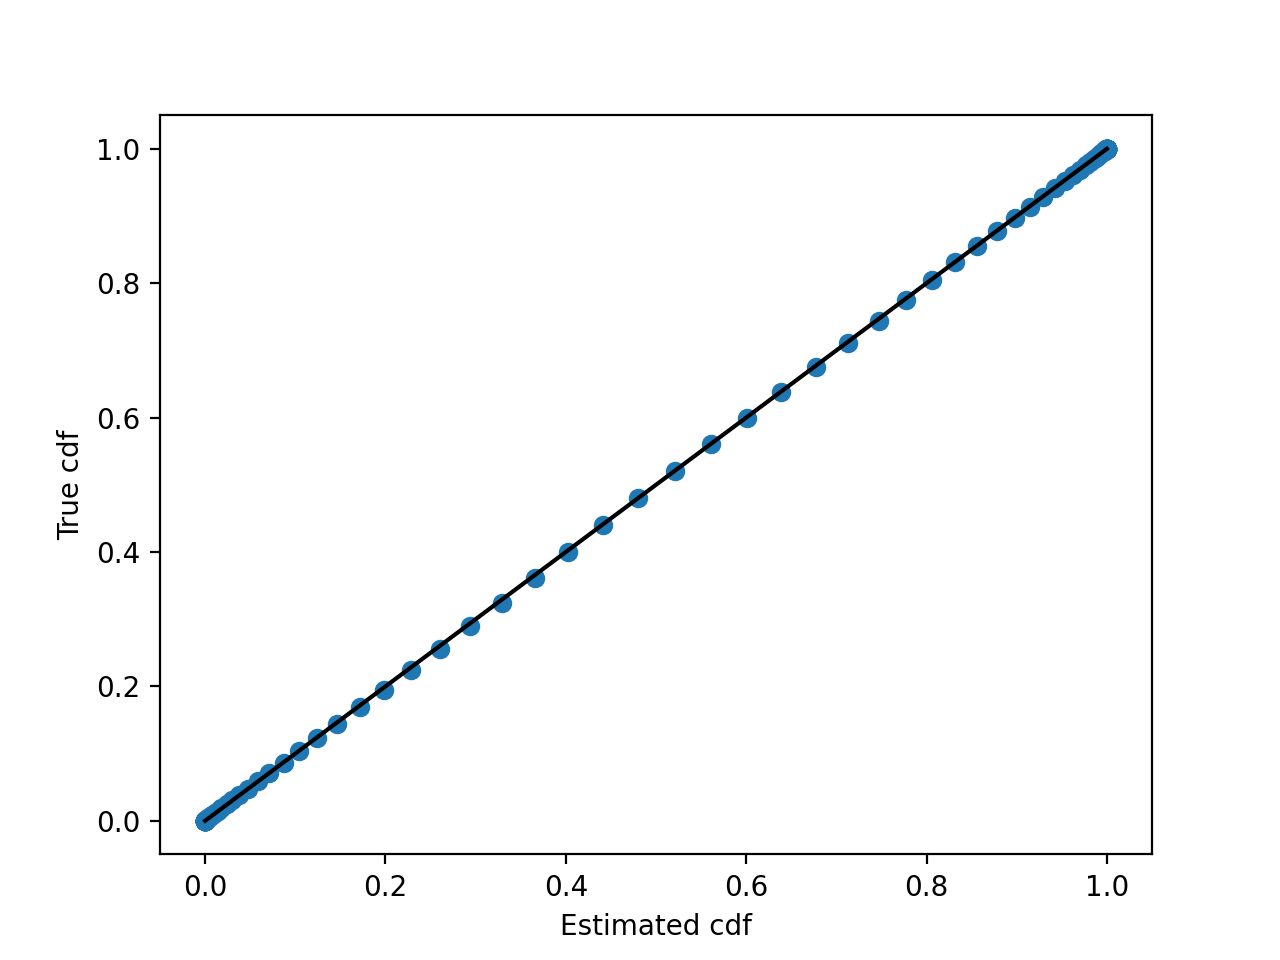

[None, None]

In [5]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], 1) for i in range(2)]

# Correlated Gaussian

In [6]:
t = pints.Timer()
test = run_replicates(np.geomspace(5000, 20000, 8), 10, ss.correlated_gaussian, parallel=parallel)
print(t.format())

26 minutes, 15 seconds


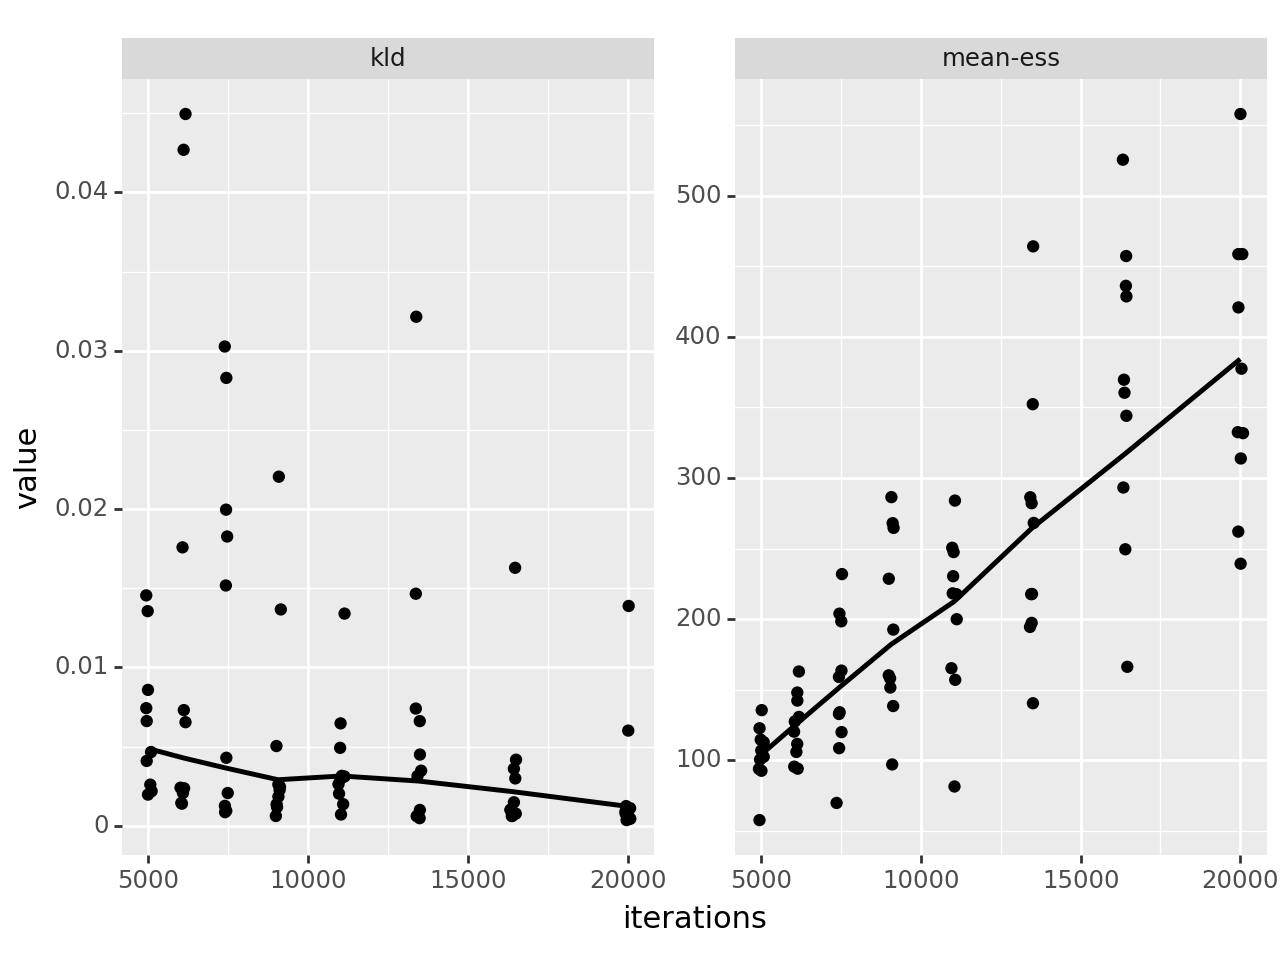

<Figure Size: (640 x 480)>

In [7]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))

Example run of results.

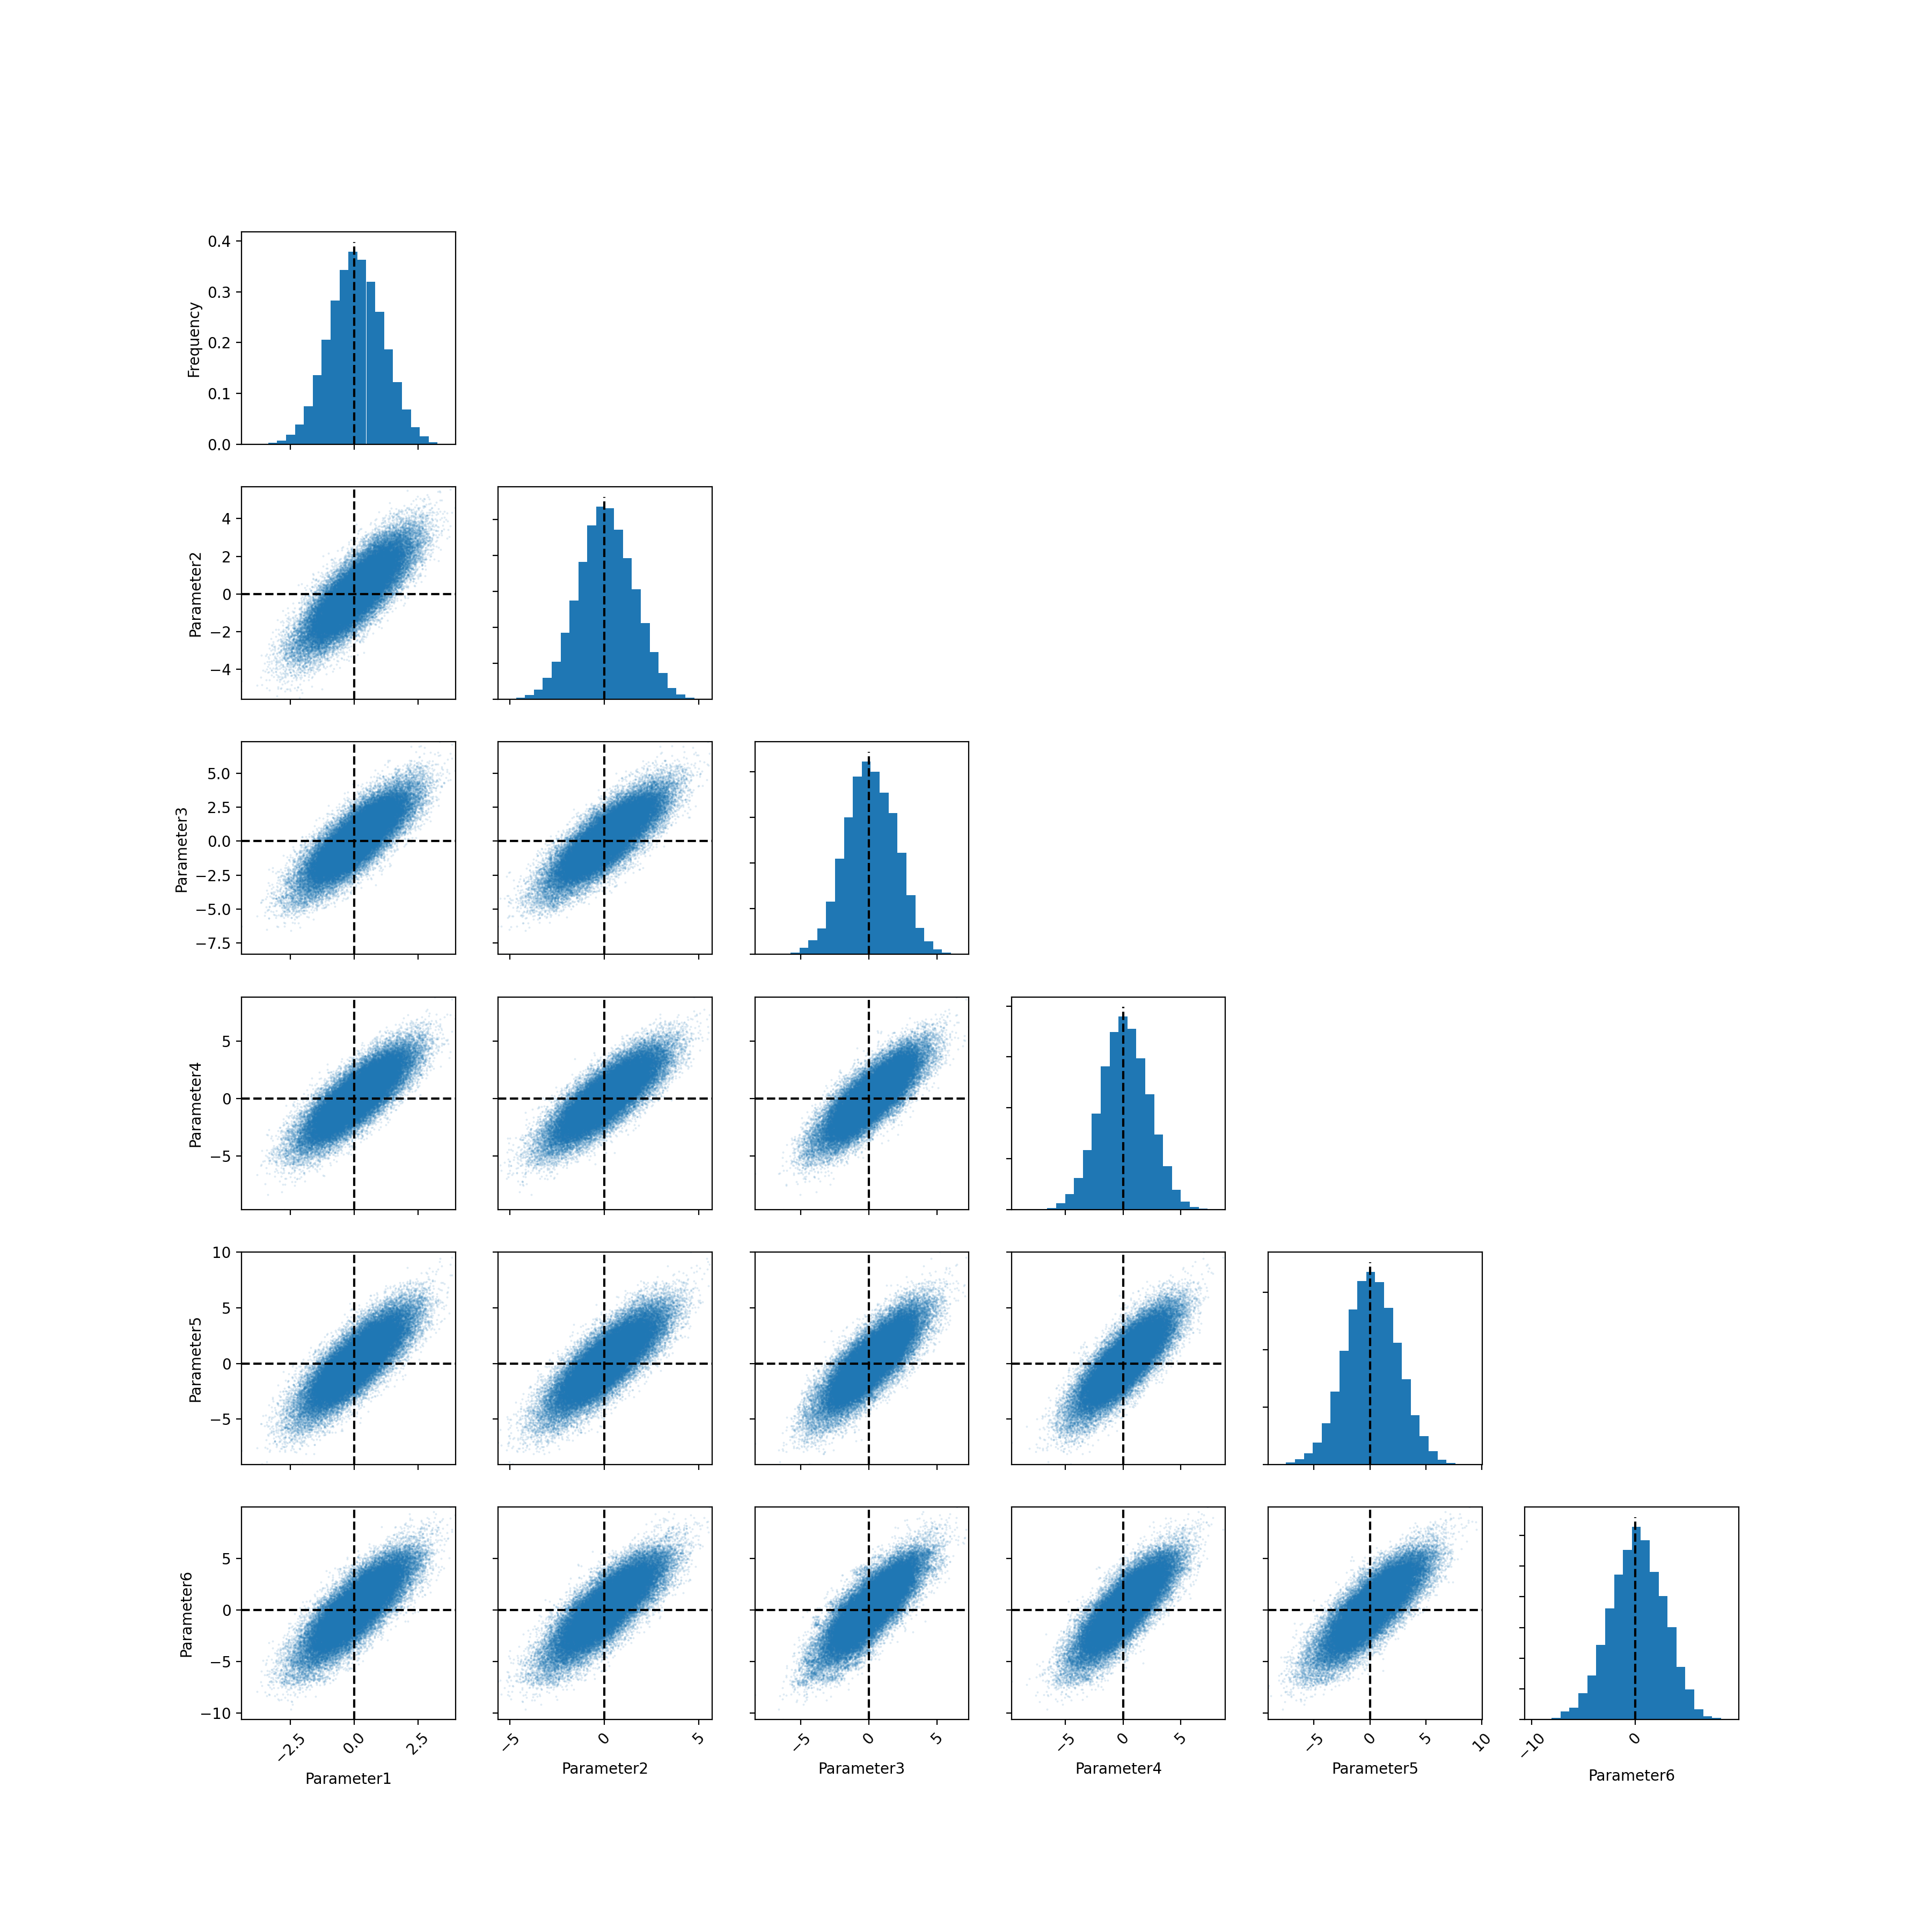

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.07    1.04    -1.96   -0.64  0.06   0.79   2.11     1.00    1159.19  11.76
param 2  0.10    1.47    -2.79   -0.89  0.08   1.10   2.97     1.00    1124.16  11.41
param 3  0.14    1.82    -3.43   -1.11  0.12   1.44   3.62     1.00    1050.81  10.66
param 4  0.14    2.08    -3.94   -1.27  0.13   1.57   4.18     1.00    1136.32  11.53
param 5  0.16    2.33    -4.42   -1.42  0.16   1.76   4.72     1.00    1105.25  11.21
param 6  0.18    2.58    -4.98   -1.56  0.21   1.97   5.06     1.00    1071.80  10.88


In [8]:
n_chains = 4
n_iterations = 20000
n_warmup = 5000

log_pdf = pints.toy.HighDimensionalGaussianLogPDF(dimension=6, rho=0.8)
x0 = np.random.uniform(-4, 4, size=(n_chains, 6))
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.SliceStepoutMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

chains = controller.run()
chains = chains[:, n_warmup:]

# Show traces and histograms
pints.plot.pairwise(np.vstack(chains), kde=False, ref_parameters=([0] * 6))

# Show graphs
plt.show()

results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

Again the estimated means compare well with the theoretical. Now comparing the theoretical and empirical cdfs: again, these look fine.

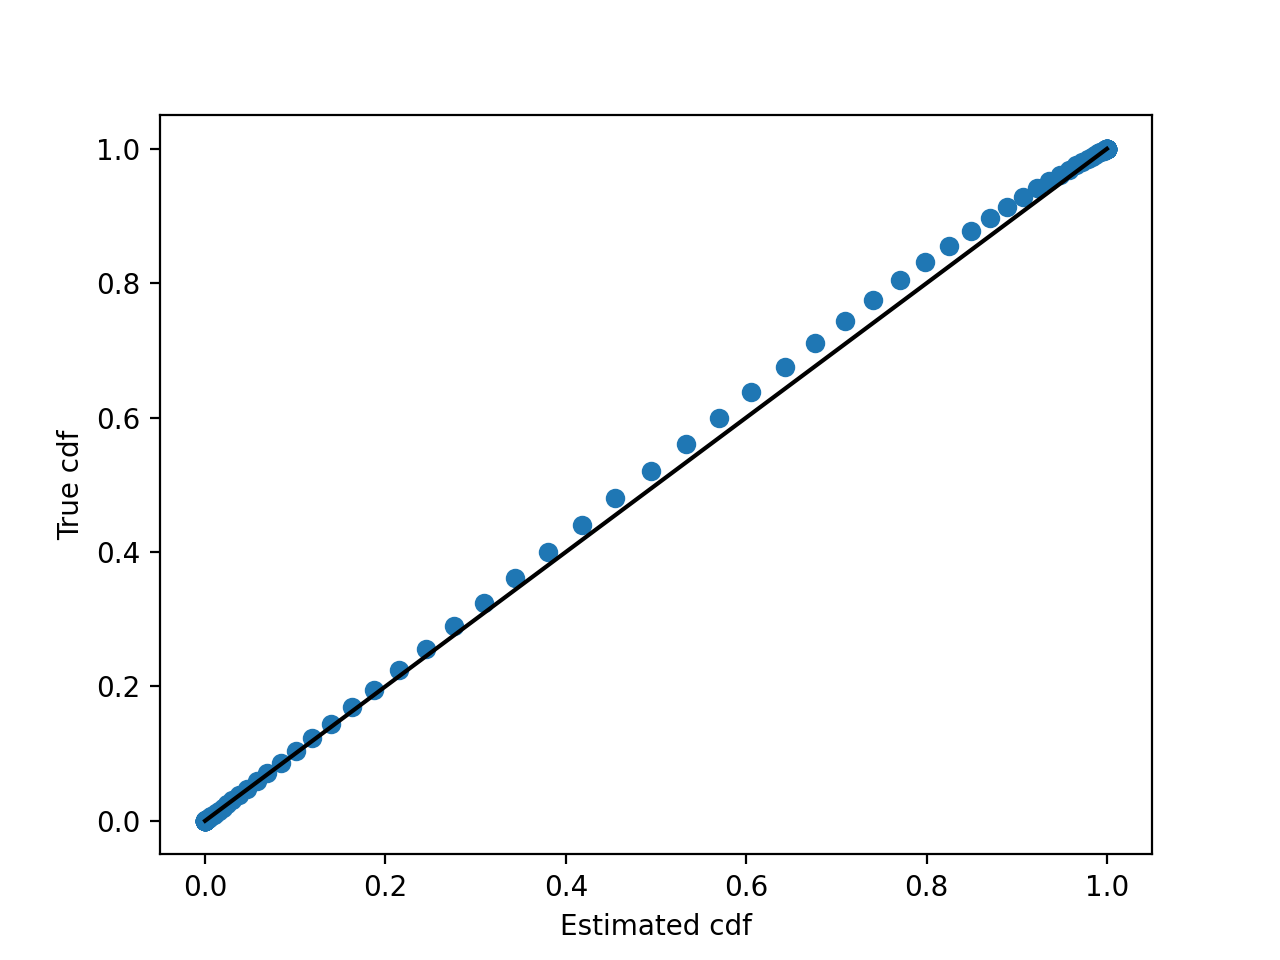

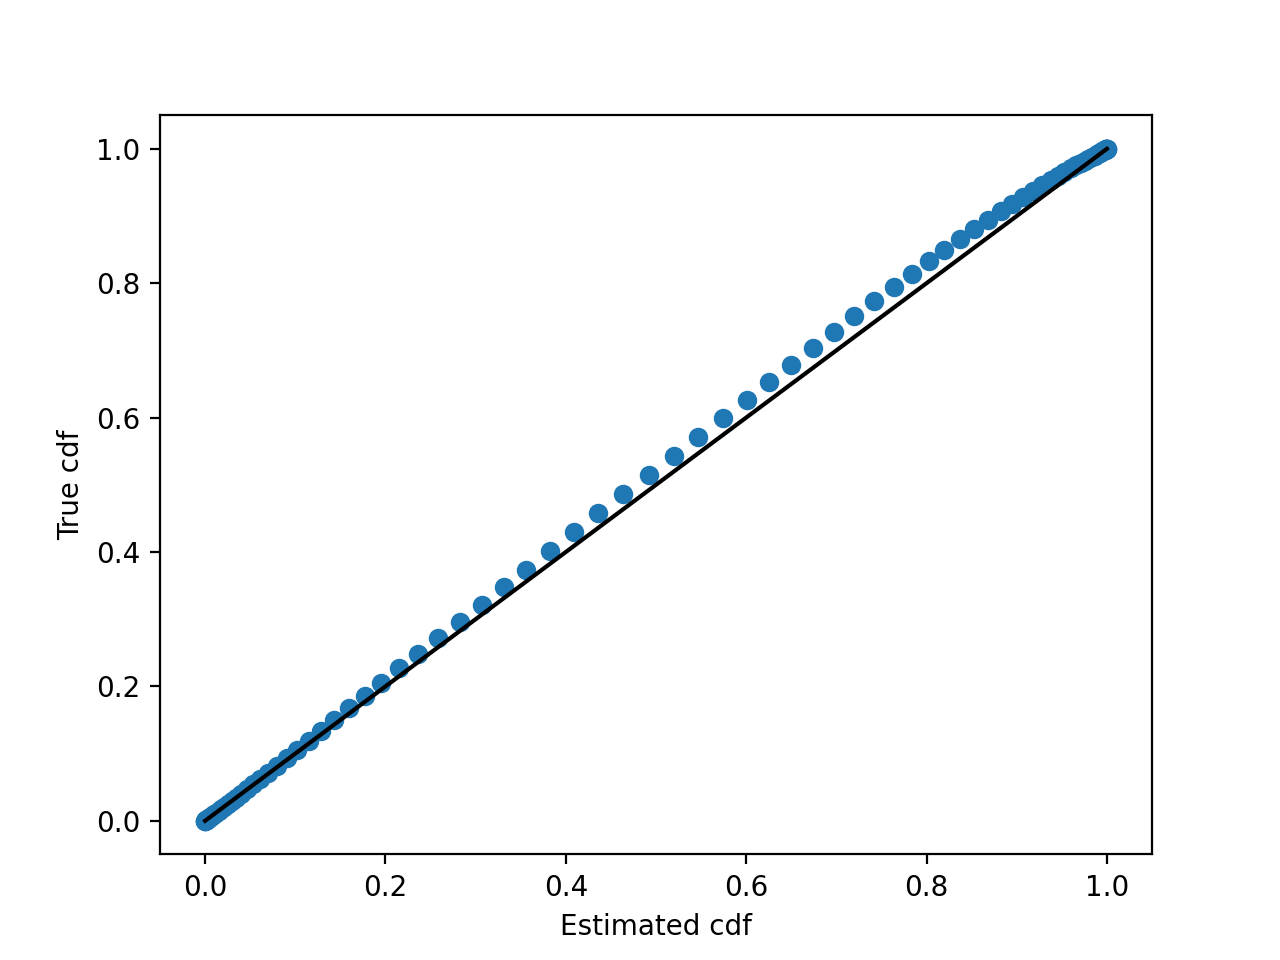

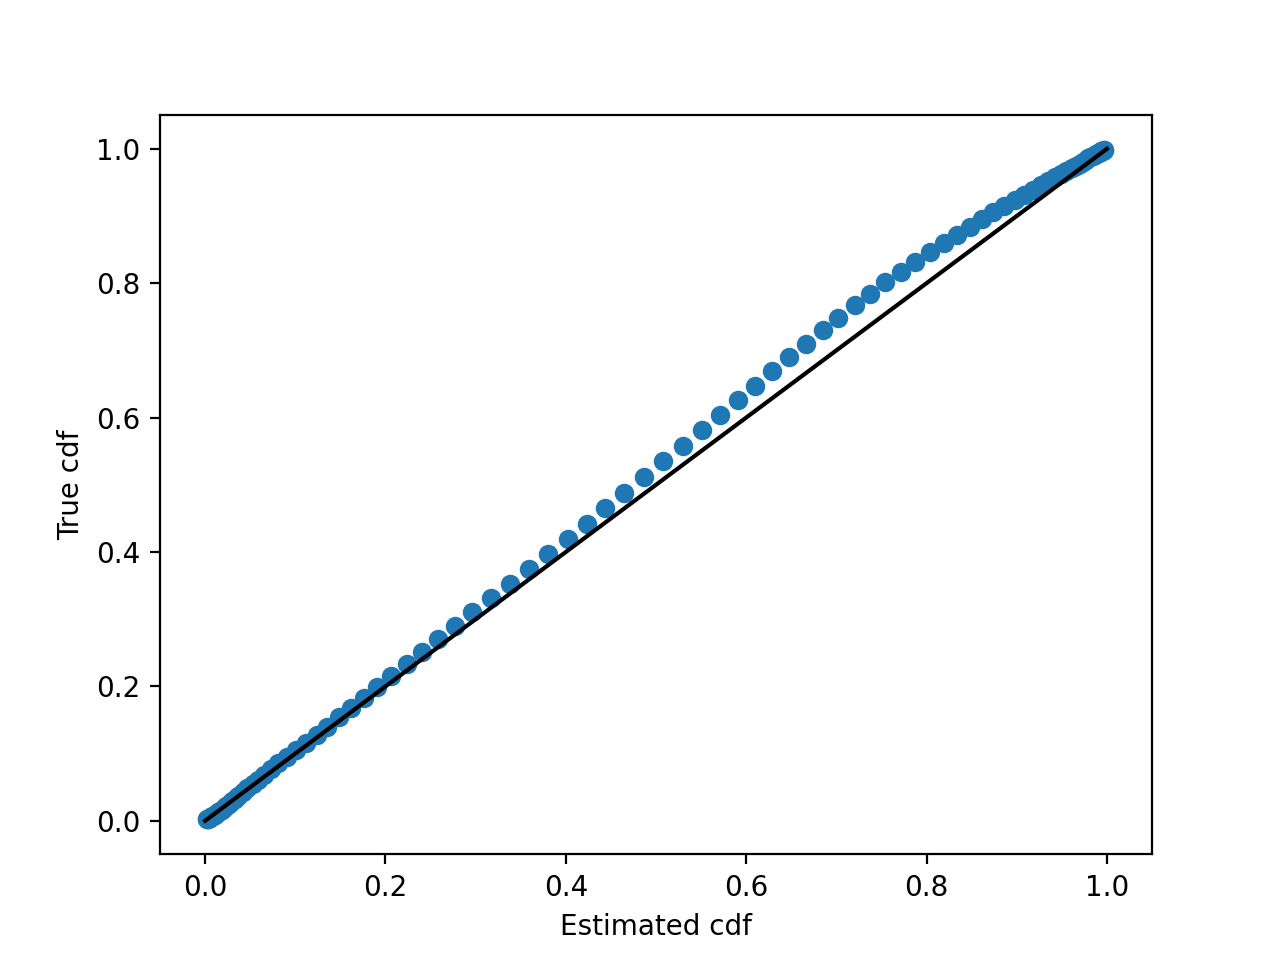

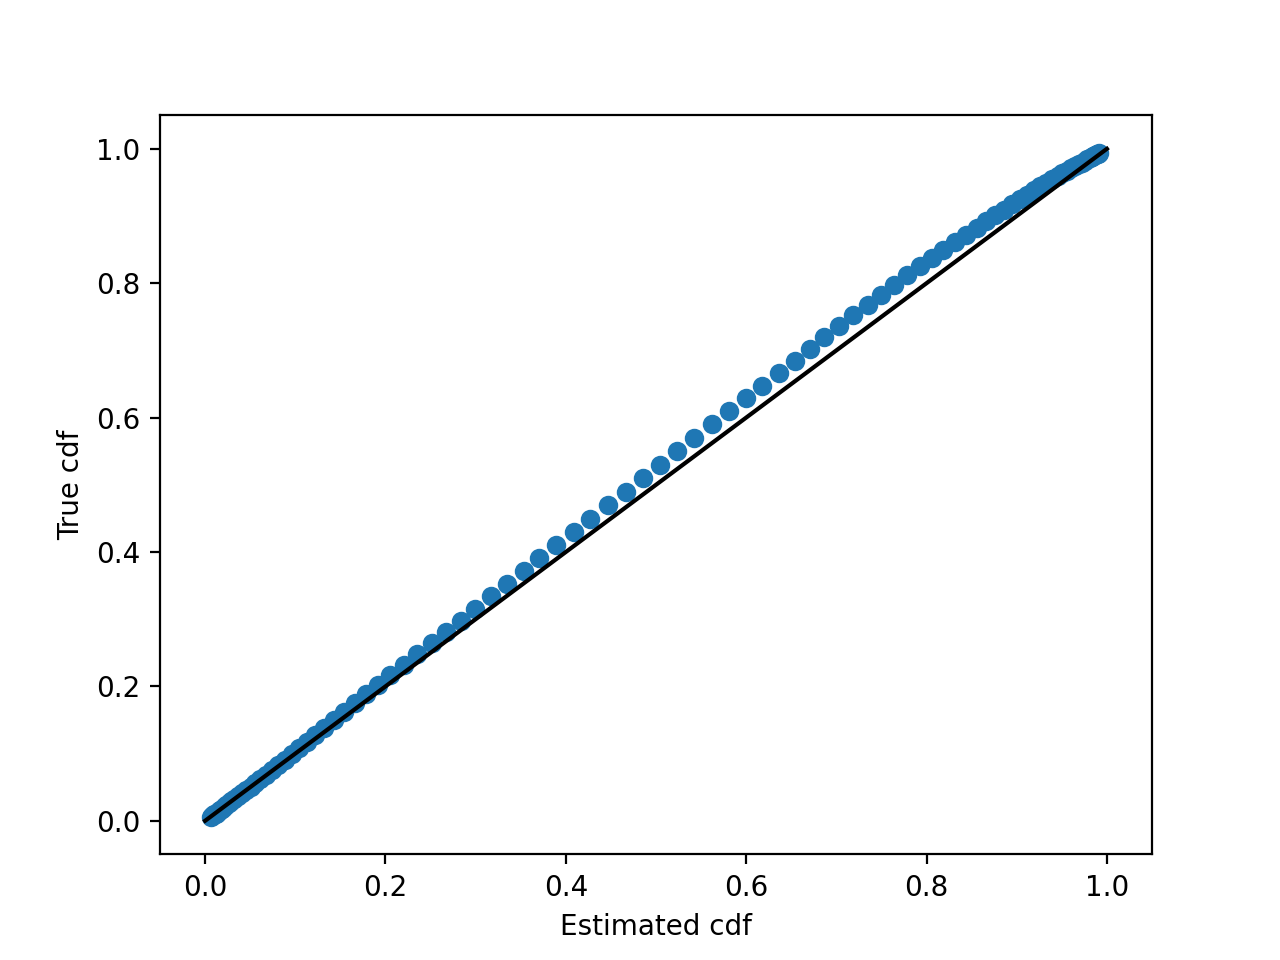

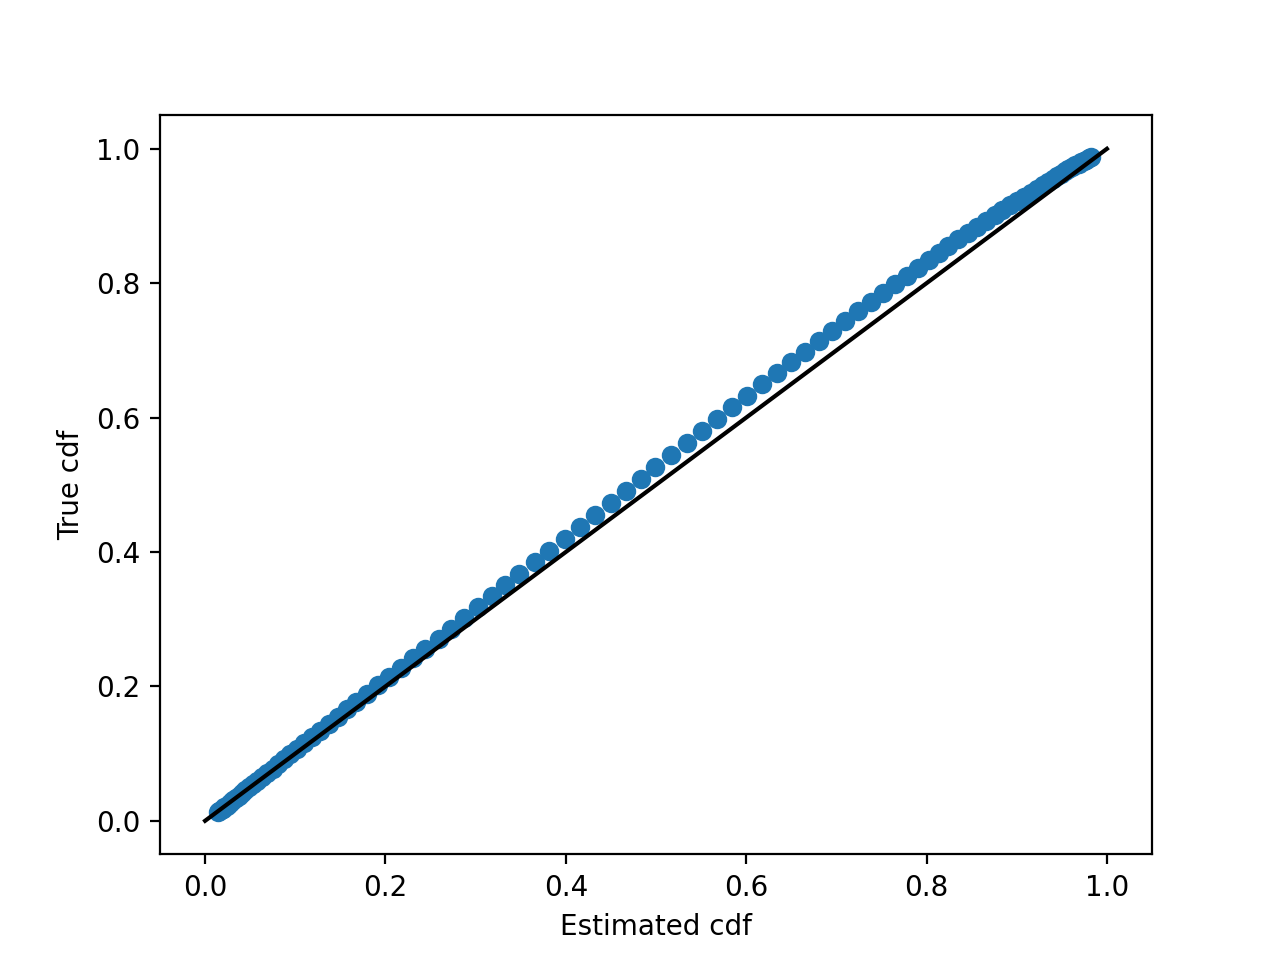

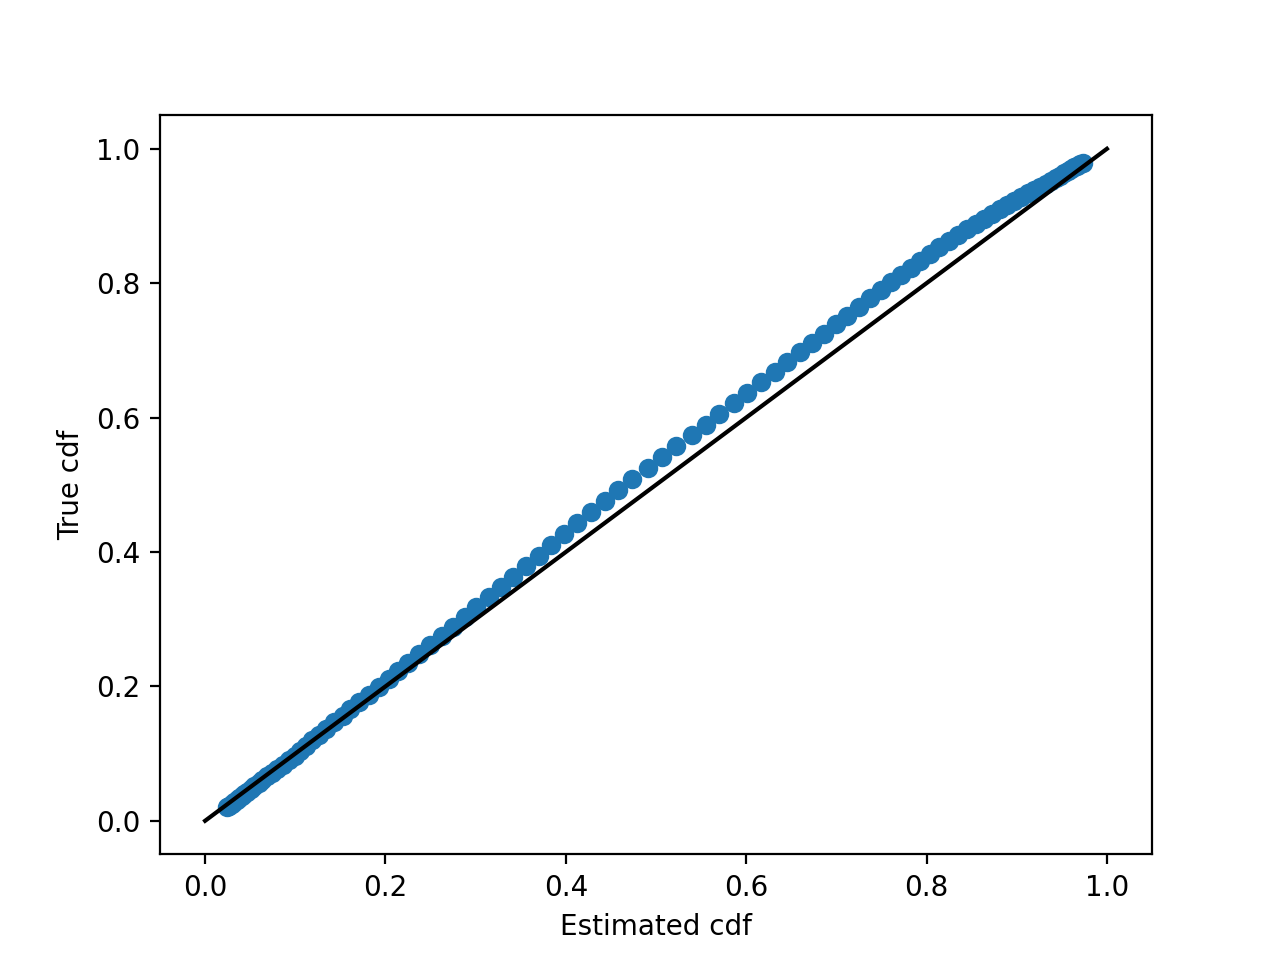

[None, None, None, None, None, None]

In [9]:
draws = np.vstack(chains)
[ecdf_norm_plotter(draws[:, i], np.sqrt(i + 1)) for i in range(6)]

# Annulus

In [10]:
t = pints.Timer()
test = run_replicates(np.geomspace(3000, 10000, 8), 10, ss.annulus, parallel=parallel)
print(t.format())

18 minutes, 51 seconds


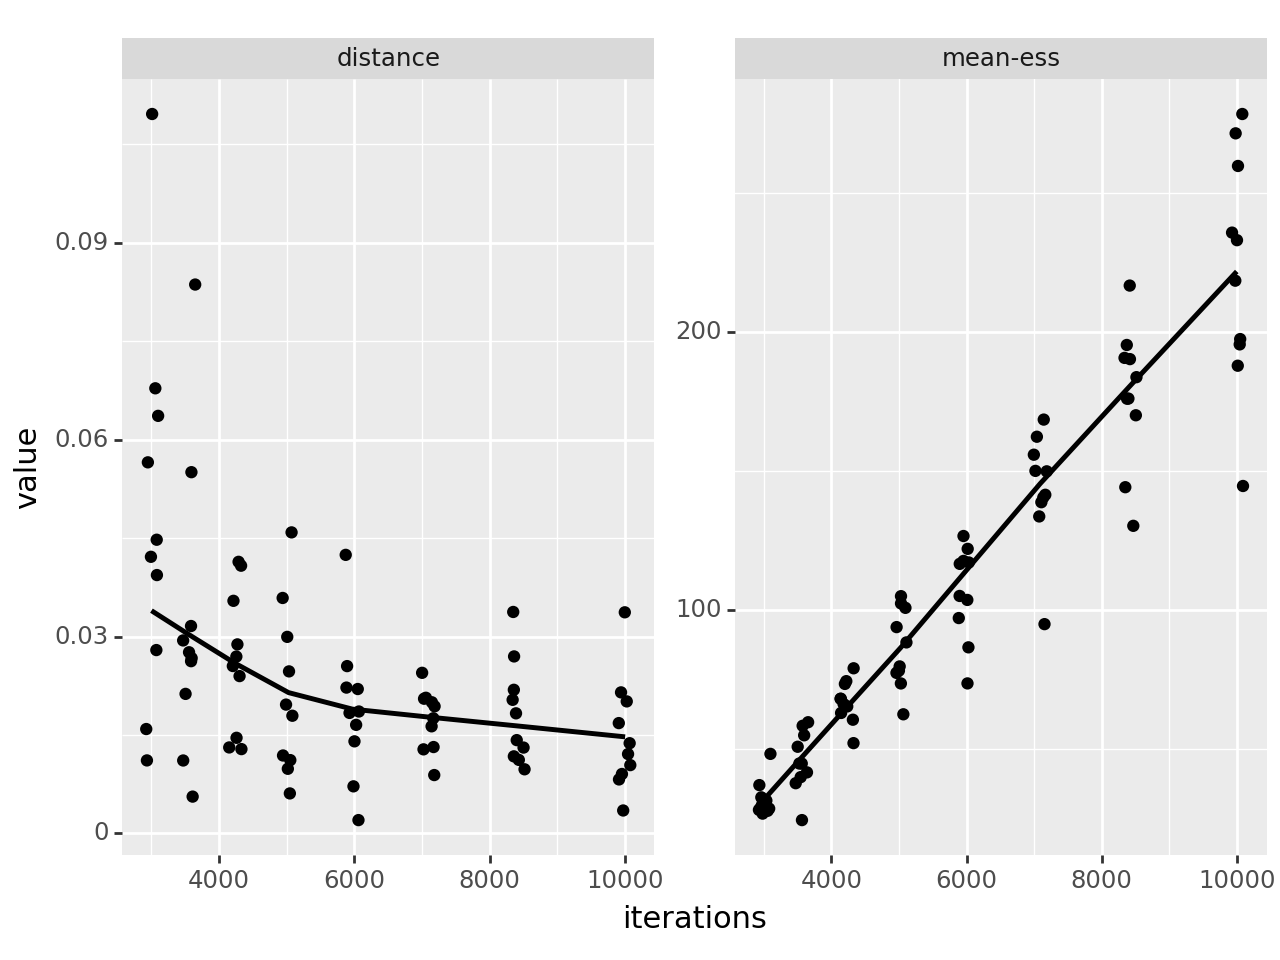

<Figure Size: (640 x 480)>

In [11]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))

The draws trend closer to convergence as the number of iterations increases.

Example run.

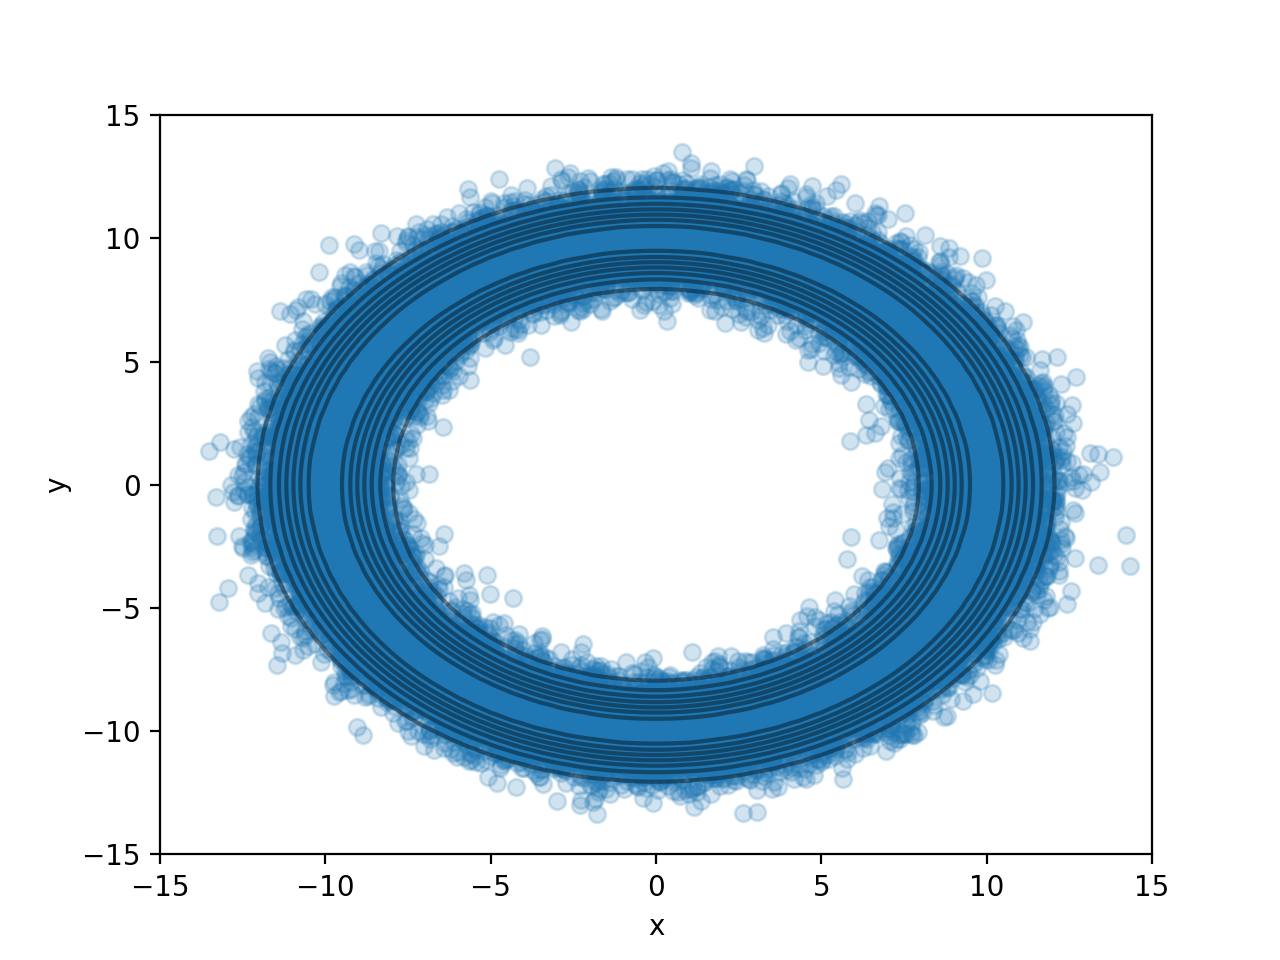

In [12]:
n_chains = 4
n_iterations = 10000
n_warmup = 2000

log_pdf = pints.toy.AnnulusLogPDF()
x0 = log_pdf.sample(n_chains)

# run model
controller = pints.MCMCController(
            log_pdf, n_chains, x0, sigma0=None, method=pints.SliceStepoutMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

chains = controller.run()
chains = np.vstack(chains[:, n_warmup:])

num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.4)
plt.scatter(chains[:, 0], chains[:, 1], alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Cone

In [13]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 10000, 8), 10, ss.cone, parallel=parallel)
print(t.format())

1 minute, 7 seconds


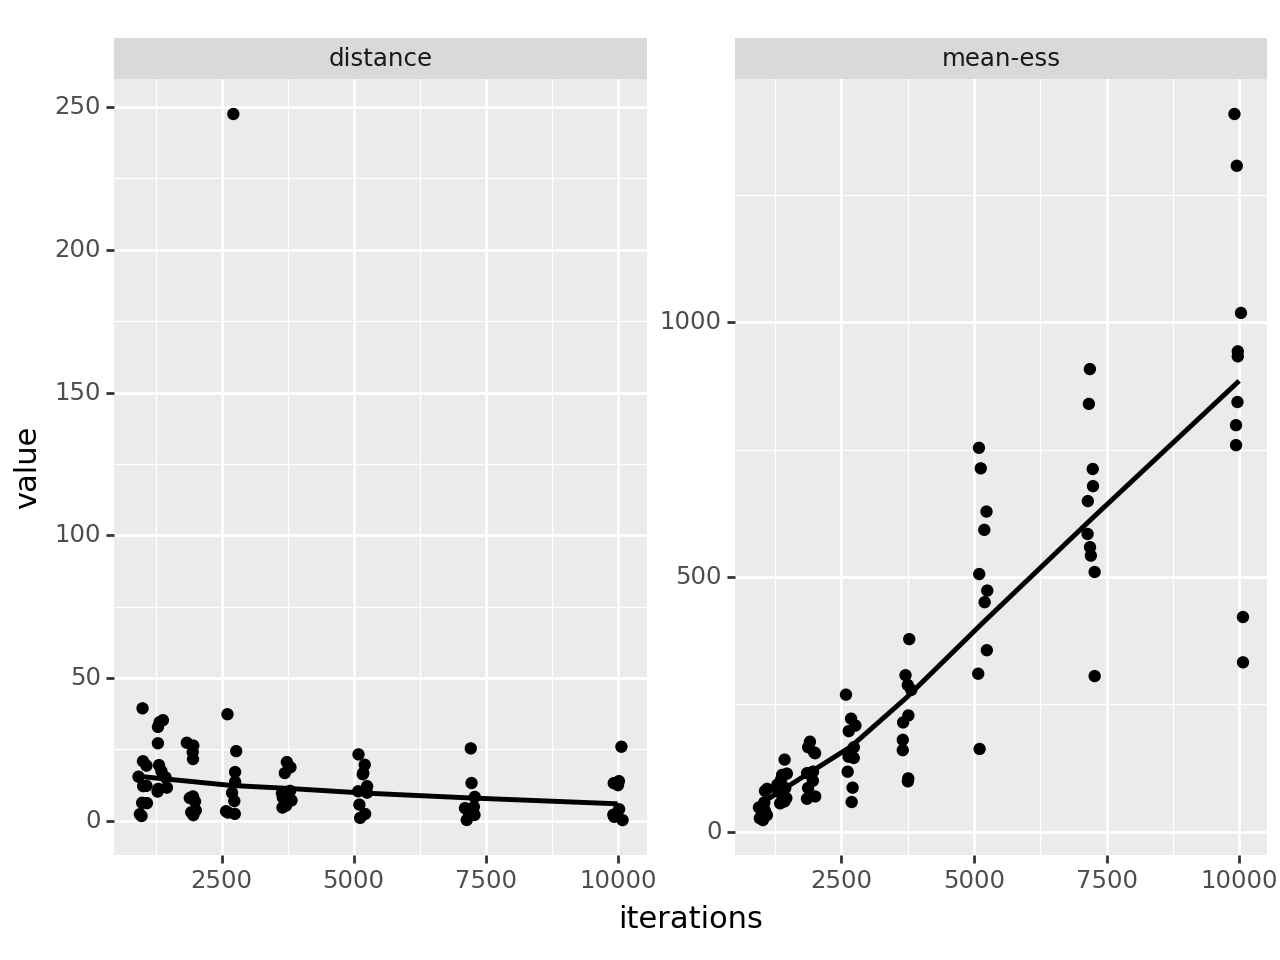

<Figure Size: (640 x 480)>

In [14]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))

Again, the cone problem, with its long tails, is really hard.

Now showing an example run.

Running...
Done!
param       mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
----------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
mean dim 1  -0.31   8.10    -18.48  -3.58  -0.11  2.99   16.45    1.01    1392.50  416.26
mean dim 2  0.18    7.60    -16.24  -3.21  0.06   3.35   17.01    1.00    1918.14  573.39


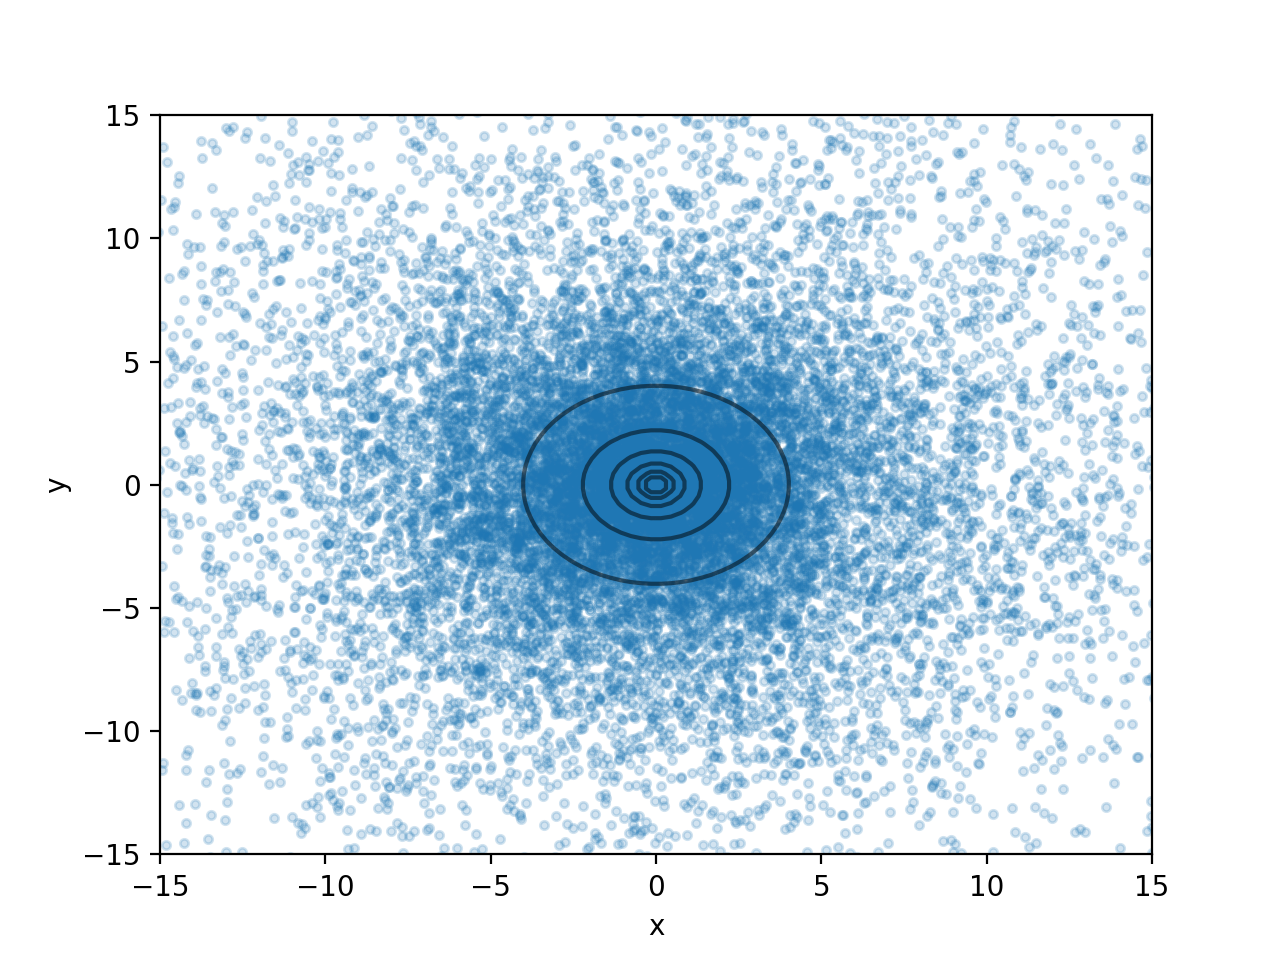

True normed mean = 8.638816024714002
Sample normed mean = 8.231119761135611
True normed var = 65.40423915068341
Sample normed var = 56.88667159979156


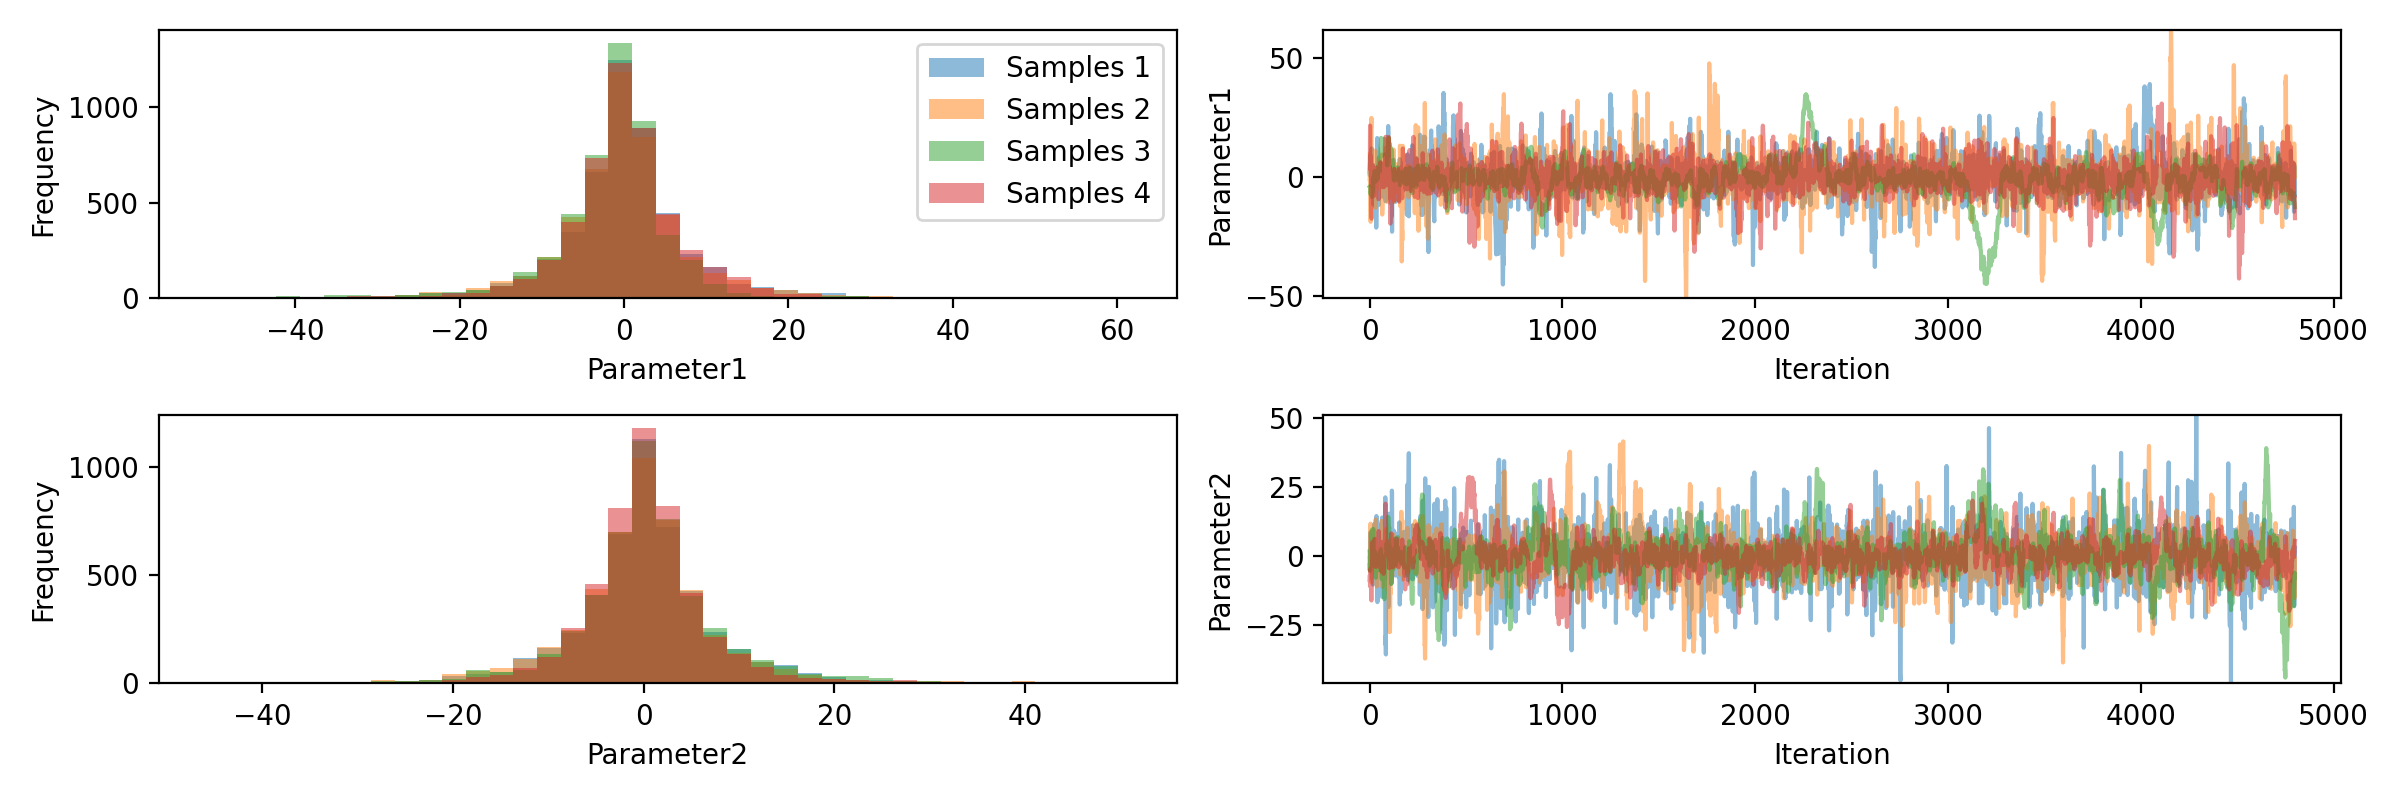

In [15]:
nchains = 4
log_pdf = pints.toy.ConeLogPDF(dimensions=2, beta=0.6)
x0 = log_pdf.sample(nchains)
mcmc = pints.MCMCController(log_pdf, nchains, x0, method=pints.SliceStepoutMCMC)

# Set maximum number of iterations
mcmc.set_max_iterations(5000)

# Disable logging
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(),
                            parameter_names=['mean dim 1', 'mean dim 2'])
print(results)

# Discard warm-up
chains = [chain[200:] for chain in chains]
stacked = np.vstack(chains)

# overlay draws on contours
num_points = 100
x = np.linspace(-15, 15, num_points)
y = np.linspace(-15, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z, colors='k', alpha=0.5)
plt.scatter(stacked[:,0], stacked[:,1], marker='.', alpha=0.2)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

d = list(map(lambda x: np.linalg.norm(x), stacked))
a_mean = np.mean(d)
a_var = np.var(d)

print("True normed mean = " + str(log_pdf.mean_normed()))
print("Sample normed mean = " + str(a_mean))

print("True normed var = " + str(log_pdf.var_normed()))
print("Sample normed var = " + str(a_var))

# Show traces and histograms
pints.plot.trace(chains)
plt.show()

# High dimensional Gaussian

In [16]:
t = pints.Timer()
test = run_replicates(np.geomspace(1000, 10000, 8), 10, ss.high_dim_gaussian, parallel=parallel)
print(t.format())

1 hour, 20 minutes, 27 seconds


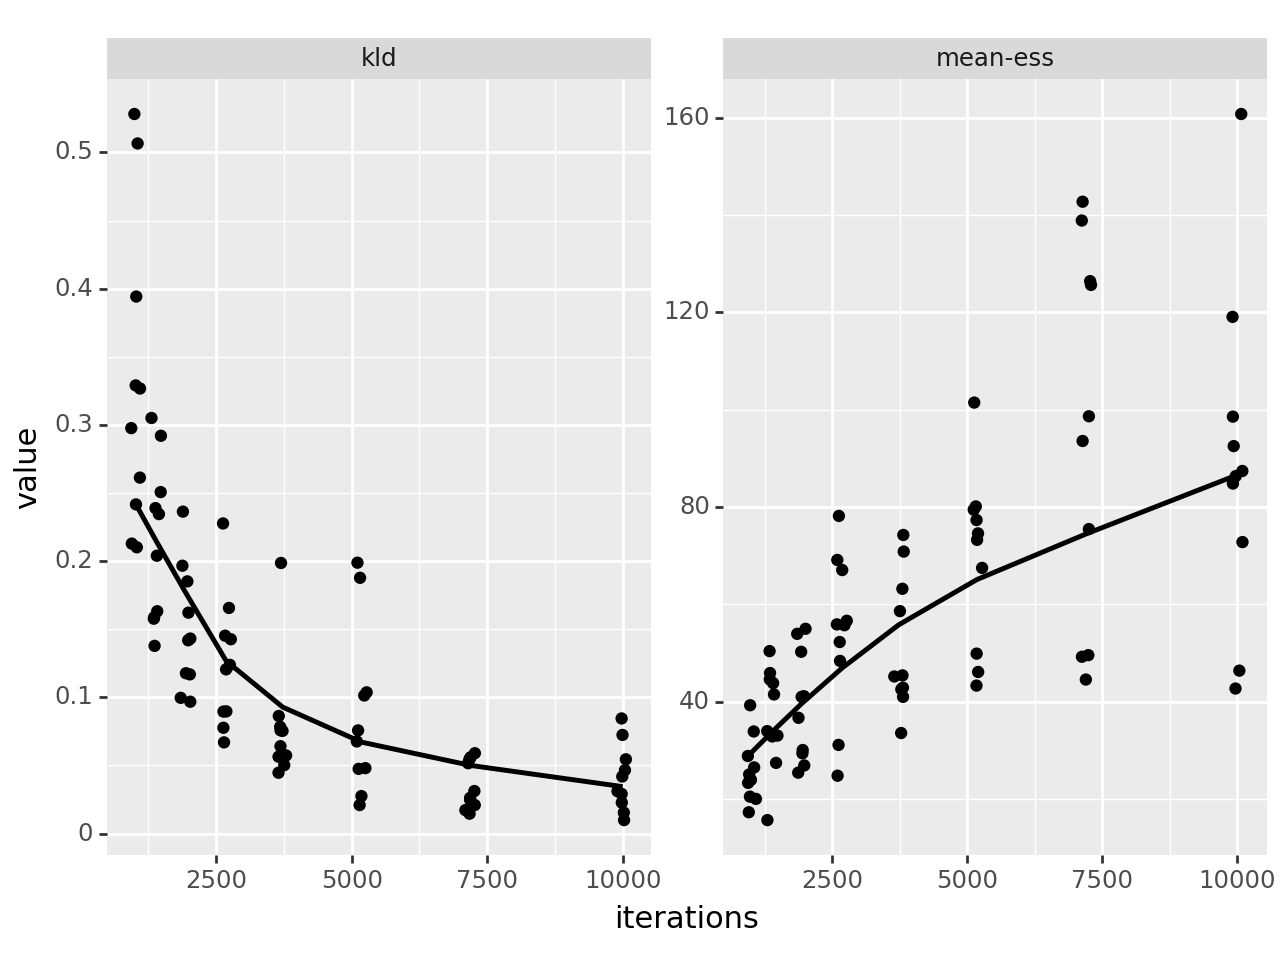

<Figure Size: (640 x 480)>

In [17]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free'))